### Задание:

Выберите одну из трех фичей для анализа
* Понижение коэффициента surge, чтобы увеличить price-to-order конверсию (во время surge)
  Ожидаем: выше price-to-order конверсия во время surge
* Если юзер Android нажимает “отменить”, предлагать промокод в случае НЕ отмены
  Ожидаем: ниже отмены на Android устройствах
* При уточнении, уверен ли юзер в отмене заказа не из центра, добавить эмодзи котика, просящего не отменять
  Ожидаем: ниже отмены по заказам НЕ из центра

Отфильтруйте датасет по своей гипотезе. Используйте метрику, которая описана в блоке “Ожидаем”

Постройте периодический p-value по выбранной метрике (сплит уже произведен)
* Разбейте общее количество наблюдений на 7 участков (используйте столбец даты)
* Для каждого участка используйте встроенную функцию ТТЕСТ() в excel, чтобы сравнить тестовую и котрольную группы
* 7 полученных значений p-value визуализируйте на графике

На основе графика сделайте вывод о значимости результатов.


Фича: если юзер Android нажимает “отменить”, предлагать промокод в случае НЕ отмены

Ожидаем: ниже отмены на Android устройствах

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import scipy.stats as stats

In [2]:
df = pd.read_csv('post_abtest_data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101500 entries, 0 to 101499
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   user_id            101500 non-null  int64  
 1   date               101500 non-null  object 
 2   app_opened         101500 non-null  int64  
 3   group              101500 non-null  object 
 4   price_seen         101500 non-null  int64  
 5   order_made         101500 non-null  int64  
 6   surge              92358 non-null   object 
 7   os                 101500 non-null  object 
 8   user_cancelled     70157 non-null   float64
 9   city_center_order  70157 non-null   float64
 10  groups             101500 non-null  object 
dtypes: float64(2), int64(4), object(5)
memory usage: 8.5+ MB


In [4]:
df.head(10)

,user_id,date,app_opened,group,price_seen,order_made,surge,os,user_cancelled,city_center_order,groups
0,867689,2020-05-28,1,Control,1,1,no surge,Android,0.0,1.0,Control
1,867689,2020-05-29,1,Control,1,0,surge,iOS,NaN,NaN,Control
2,867689,2020-05-25,1,Control,1,1,surge,Android,0.0,0.0,Control
3,752172,2020-05-29,1,Control,1,1,surge,Android,0.0,1.0,Control
4,752172,2020-05-28,1,Control,1,1,no surge,iOS,0.0,0.0,Control
5,486559,2020-05-25,1,Control,1,0,surge,Android,NaN,NaN,Control
6,486559,2020-05-31,1,Control,1,1,no surge,iOS,0.0,0.0,Control
7,486559,2020-05-30,1,Control,1,1,no surge,Android,0.0,0.0,Control
8,486559,2020-05-28,1,Control,1,0,surge,iOS,NaN,NaN,Control
9,486559,2020-05-29,1,Control,1,1,no surge,Android,0.0,0.0,Control


In [5]:
android = df[(df['os'] == 'Android') & (df['order_made'] == 1)]
android

,user_id,date,app_opened,group,price_seen,order_made,surge,os,user_cancelled,city_center_order,groups
0,867689,2020-05-28,1,Control,1,1,no surge,Android,0.0,1.0,Control
2,867689,2020-05-25,1,Control,1,1,surge,Android,0.0,0.0,Control
3,752172,2020-05-29,1,Control,1,1,surge,Android,0.0,1.0,Control
7,486559,2020-05-30,1,Control,1,1,no surge,Android,0.0,0.0,Control
9,486559,2020-05-29,1,Control,1,1,no surge,Android,0.0,0.0,Control
...,...,...,...,...,...,...,...,...,...,...,...
101490,600165,2020-05-25,1,Control,1,1,no surge,Android,0.0,1.0,Control
101491,556405,2020-05-29,1,Control,1,1,no surge,Android,0.0,1.0,Control
101493,442716,2020-05-26,1,Test,1,1,surge,Android,0.0,1.0,Test
101497,352605,2020-05-26,1,Test,1,1,no surge,Android,0.0,1.0,Test


In [6]:
android = android.groupby(['user_id','groups','date']).agg({'user_cancelled':'sum'}).reset_index()
android

,user_id,groups,date,user_cancelled
0,100093,Test,2020-05-25,0.0
1,100118,Test,2020-05-29,1.0
2,100118,Test,2020-05-30,0.0
3,100134,Test,2020-05-27,1.0
4,100134,Test,2020-05-31,0.0
...,...,...,...,...
37416,999945,Test,2020-05-30,0.0
37417,999962,Control,2020-05-25,0.0
37418,999978,Control,2020-05-26,0.0
37419,999978,Control,2020-05-29,0.0


In [7]:
len(android[android['groups']=='Test'])

18899

In [8]:
len(android[android['groups']=='Control'])

18522

In [9]:
android.date.unique()

array(['2020-05-25', '2020-05-29', '2020-05-30', '2020-05-27',
       '2020-05-31', '2020-05-28', '2020-05-26'], dtype=object)

In [10]:
day1_c = android[(android.date == '2020-05-25') & (android.groups == 'Control')]['user_cancelled'].dropna().sample(n=2600)
day1_t = android[(android.date == '2020-05-25') & (android.groups == 'Test')]['user_cancelled'].dropna().sample(n=2600)

In [11]:
day2_c = android[(android.date == '2020-05-26') & (android.groups == 'Control')]['user_cancelled'].dropna().sample(n=2600)
day2_t = android[(android.date == '2020-05-26') & (android.groups == 'Test')]['user_cancelled'].dropna().sample(n=2600)

In [12]:
day3_c = android[(android.date == '2020-05-27') & (android.groups == 'Control')]['user_cancelled'].dropna().sample(n=2600)
day3_t = android[(android.date == '2020-05-27') & (android.groups == 'Test')]['user_cancelled'].dropna().sample(n=2600)

In [13]:
day4_c = android[(android.date == '2020-05-28') & (android.groups == 'Control')]['user_cancelled'].dropna().sample(n=2600)
day4_t = android[(android.date == '2020-05-28') & (android.groups == 'Test')]['user_cancelled'].dropna().sample(n=2600)

In [14]:
day5_c = android[(android.date == '2020-05-29') & (android.groups == 'Control')]['user_cancelled'].dropna().sample(n=2600)
day5_t = android[(android.date == '2020-05-29') & (android.groups == 'Test')]['user_cancelled'].dropna().sample(n=2600)

In [15]:
day6_c = android[(android.date == '2020-05-30') & (android.groups == 'Control')]['user_cancelled'].dropna().sample(n=2600)
day6_t = android[(android.date == '2020-05-30') & (android.groups == 'Test')]['user_cancelled'].dropna().sample(n=2600)

In [16]:
day7_c = android[(android.date == '2020-05-31') & (android.groups == 'Control')]['user_cancelled'].dropna().sample(n=2600)
day7_t = android[(android.date == '2020-05-31') & (android.groups == 'Test')]['user_cancelled'].dropna().sample(n=2600)

In [17]:
len(day1_c), len(day1_t)

(2600, 2600)

In [18]:
control = [day1_c, day2_c, day3_c, day4_c, day5_c, day6_c, day7_c]
test = [day1_t, day2_t, day3_t, day4_t, day5_t, day6_t, day7_t]

In [19]:
Pvalue = []
for i in range(7):
    T, p = stats.ttest_ind(control[i], test[i])
    Pvalue.append(p)

Pvalue

[0.04284150545252369,
 0.0001789541412677332,
 1.59454383967388e-07,
 1.587835151677373e-05,
 4.098432653002409e-07,
 5.090569761564202e-06,
 5.205327872803953e-05]

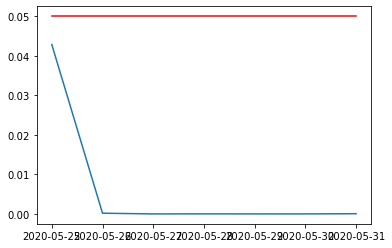

In [20]:
alpha=0.05

fig, ax = plt.subplots() 
ax.plot(sorted(android['date'].unique()), Pvalue)
ax.plot(sorted(android['date'].unique()), [alpha]*7, color='red')

P-value ниже alpha => **предложение промокода юзерам Android при нажатии кнопки отмены заказа приводит к сокращению отмен. Фича работает.**